In [58]:
# TO DO:
# - Fix NA
# - Fix manglende data punkter i plot
# - Lav mere analyse af data generelt (mean comment length for each candidate, mean word length, etch.)

# - Faldgrupper:
#    - Clinton finder også Bill Clinton
#    - Inkluder flere søgeord? Shillary, Bernie, etc.
#    - Bruger wikipedia, kunne analysere hver poll for sig selv. Alt for meget arbejde i forhold til dette projetk
#    - Head-to-head race makes it impossible to compare Bernie to Hillary, Trump to Cruz
#    - Imputation for missing values for linear regression
#    - Afsnit om kandidater, ind og ud af løbet-
#    - fdates and epochs made from FIRST date of time span
#    - Opdater latex med nye grid plots i (18,6)-format
#    - Linear fit med nye titler
#    - Indsæt grafer for normalfordling og resultat af Shapiro Wilks test

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dan\AppData\Roaming\nltk_data...


True

# Import and init functions

In [1]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from datetime import datetime
import numpy as np
import json
import os
import time
import string
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import re
import pickle
from operator import itemgetter
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pylab
from sklearn import preprocessing

matplotlib.rcParams.update({'font.size': 12})
pd.set_option('display.max_colwidth', -1)


#params = {'axes.labelsize': 18,'axes.titlesize':20, 'text.fontsize': 50, 'legend.fontsize': 20, 'xtick.labelsize': 28, 'ytick.labelsize': 40}
#matplotlib.rcParams.update(params)

# Convert to epoch
def timeConvert(date):
	return time.mktime(datetime.strptime(date, '%Y-%m-%d').timetuple())
# Convert from epoch to Y-M-D
def timeInvert(epoch):
	return time.strftime('%Y-%m-%d', time.localtime(epoch))


# List of epoch times for iteration
start = []
timeTuples = []
for i in ["%.2d" % i for i in range(3,13)]:
	start.append('2015-'+i+'-01')
for idx, date in enumerate(start[:-1]):
	timeTuples.append((timeConvert(date),timeConvert(start[idx+1])))
timeTuples.append((timeConvert('2015-12-01'),timeConvert('2015-12-31')))

start = []
for i in ["%.2d" % i for i in range(1,13)]:
	start.append('2016-'+i+'-01')
for idx, date in enumerate(start[:-1]):
	timeTuples.append((timeConvert(date),timeConvert(start[idx+1])))
timeTuples.append((timeConvert('2016-12-01'),timeConvert('2016-12-31')))




# Cleaning

In [64]:

# Alpha-num, lowercase
def easy_clean(comment):
    comment = re.sub('[^A-Za-z ]+', '', comment['body']).lower().split(' ')
    #comment = [re.sub('[^A-Za-z]+', '', word) for word in comment]
    return comment

# nltk tokenize, stopwords
def nltk_clean(comment):
    #comment = comment
    #comment = nltk.sent_tokenize(comment)
    print(comment)
    comment = nltk.tokenize.word_tokenize(comment)
    comment = [word for word in comment if word.isalpha()]
    stop_words = nltk.corpus.stopwords.words('english')
    comment = [word for word in comment if word not in stop_words]
    return comment

# Remove quotes, clean text using translation table (punctuations)
def nltk2_clean(comment): #tokenize, removes case, remove special characters and numbers
    comment = [e for e in comment.splitlines() if e[:2] != '&g']
    comment = ' '.join(comment)
    comment = comment.split(' ')
    #comment = [w.lower() for w in comment]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in comment]
    words = [word for word in comment]
    return ' '.join(words)

# Tokenize at sentence level, applies nltk2_clean on each sentence
def clean_sent(comment): #tokenize, removes case, remove special characters and numbers
    comment = comment['body']
    comment = [e for e in comment.splitlines() if e[:2] != '&g']
    comment = ' '.join(comment)
    #comments = nltk.sent_tokenize(comment)
    #comments = [nltk2_clean(sent) for sent in comments]
    return comment


# Remove duplicates, create initial dataset

In [30]:
# Remove duplicates across dataSet
clSet = [] 
crSet = []
trSet = []
saSet = []

print('starter')
dataSet = []
start = time.time()
n = 0
for file in os.listdir('data/'):
    with open('data/'+file) as f:
        data = json.load(f)
    
    if file[:2] == 'cl':
        candidates =  ['bernie' ,'sanders' ,'donald' ,'trump' ,'ted' ,'cruz']
        #tempData = [e for e in data if not any(item in candidates for item in easy_clean(e))]
        clData = [[e,e['created_utc']] for e in data if not any(item in candidates for item in easy_clean(e))]
        clSet = clSet + clData
        
    elif file[:2] == 'cr':
        candidates =  ['bernie' ,'sanders' ,'donald' ,'trump', 'hillary', 'clinton']
        #tempData = [e for e in data if not any(item in candidates for item in easy_clean(e))]
        crData = [[e,e['created_utc']] for e in data if not any(item in candidates for item in easy_clean(e))]
        crSet = crSet + crData

    elif file[:2] == 'tr':
        candidates =  ['bernie' ,'sanders' ,'ted' ,'cruz', 'hillary', 'clinton']
        #tempData = [e for e in data if not any(item in candidates for item in easy_clean(e))]
        trData = [[e,e['created_utc']] for e in data if not any(item in candidates for item in easy_clean(e))]
        trSet = trSet + trData
        
    elif file[:2] == 'sa':
        candidates =  ['hillary', 'clinton' ,'donald' ,'trump' ,'ted' ,'cruz']
        #tempData = [e for e in data if not any(item in candidates for item in easy_clean(e))]
        saData = [[e,e['created_utc']] for e in data if not any(item in candidates for item in easy_clean(e))]
        saSet = saSet+saData
    print(file + '\ndone\n')
    
end = time.time()
print('...Done in '+str(end - start))



starter
clinton_politics_2015-03-01_2015-04-01.json
done

clinton_politics_2015-04-01_2015-05-01.json
done

clinton_politics_2015-05-01_2015-06-01.json
done

clinton_politics_2015-06-01_2015-07-01.json
done

clinton_politics_2015-07-01_2015-08-01.json
done

clinton_politics_2015-08-01_2015-09-01.json
done

clinton_politics_2015-09-01_2015-10-01.json
done

clinton_politics_2015-10-01_2015-11-01.json
done

clinton_politics_2015-11-01_2015-12-01.json
done

clinton_politics_2015-12-01_2015-12-31.json
done

clinton_politics_2016-01-01_2016-02-01.json
done

clinton_politics_2016-02-01_2016-03-01.json
done

clinton_politics_2016-03-01_2016-04-01.json
done

clinton_politics_2016-04-01_2016-05-01.json
done

clinton_politics_2016-05-01_2016-06-01.json
done

clinton_politics_2016-06-01_2016-07-01.json
done

clinton_politics_2016-07-01_2016-08-01.json
done

clinton_politics_2016-08-01_2016-09-01.json
done

clinton_politics_2016-09-01_2016-10-01.json
done

clinton_politics_2016-10-01_2016-11-01.jso

# Clean data and save/open

In [31]:
# Clean data
dataSet = [clSet, crSet, trSet, saSet]
dataSet = [[[clean_sent(comment[0]),comment[0]['created_utc']] for comment in candidate] for candidate in dataSet]


In [32]:
# Save data
with open("nodupData2", "wb") as fp:
    pickle.dump(dataSet, fp)

In [4]:
with open(r"nodupData2", "rb") as input_file:
    dataSet = pickle.load(input_file)
    

In [21]:
dataSet[0][4]


["I didn't mean just scrutinized over email, but anything - the media ia like children that get paid to make a fuss.  Scott Gration ~~was fired~~ resigned because of it, idk why powell has been ignored, probably because he's done already and Hillary is the freaking POTUS frontrunner. ",
 1426027761]

In [65]:
with open('data/trump_politics_2016-05-01_2016-06-01.json') as f:
        data = json.load(f)

        


In [66]:
a = clean_sent(data[84681])
analyzer = SIA()

#print(data[1])
#print(data[84681])
#print(a)

#print(np.mean([analyzer.polarity_scores(e)['compound'] for e in a]))

[analyzer.polarity_scores(e)['compound'] for e in a[1:]]

print(a)
#analyzer.polarity_scores(' '.join(a))['compound']



 Leading the birther movement was a racist thing that Trump chose to do. In fact, it is one of the most racist things I've witnessed in American politics in the 45 years I've been a person of color living in America.


In [61]:
a = data[84608]

#print(data[1])

print(data[84608])
print(a)

print(np.mean([analyzer.polarity_scores(e)['compound'] for e in a]))
[analyzer.polarity_scores(e)['compound'] for e in a]


NameError: name 'data' is not defined

# Compute sentiment and commentScores

In [ ]:
# Original
analyzer = SIA()
sentScores = [[[[[sentence, analyzer.polarity_scores(sentence)['compound']] 
                 for sentence in comment[0] if len(sentence)>1],comment[1]]
               for comment in candidate]
              for candidate in dataSet]

In [2]:

# Calculate average polarity score for each sentence in comment + comment in string format
commentScores = []
for candidate in sentScores:
    candidateScores = []
    for comment in candidate:
        sentence = '. '.join([sentence[0] for sentence in comment[0]])
        avg = np.mean([sentence[1] for sentence in comment[0]])
        stamp = comment[1]
        candidateScores.append([sentence, avg, stamp])
    commentScores.append(candidateScores)


NameError: name 'sentScores' is not defined

In [7]:
# Modified
analyzer = SIA()
commentScores = []

for candidate in dataSet:
    candidateScores = []
    for comment in candidate:
        sentence = comment[0]
        score = analyzer.polarity_scores(sentence)['compound']
        stamp = comment[1]
        candidateScores.append([sentence, score, stamp])
    commentScores.append(candidateScores)

In [8]:
# Save data
with open("commentScores_all2", "wb") as fp:
    pickle.dump(commentScores, fp)

In [2]:
with open(r"commentScores_all2", "rb") as input_file:
    commentScores = pickle.load(input_file)
    

# Dataframes and Plots

In [3]:
# Tuples for dataframe iteration by month
monthTuples = [["2015-03-01",  "2015-04-01"], ["2015-04-01",  "2015-05-01"], ["2015-05-01",  "2015-06-01"], ["2015-06-01",  "2015-07-01"], ["2015-07-01",  "2015-08-01"], ["2015-08-01",  "2015-09-01"], ["2015-09-01",  "2015-10-01"], ["2015-10-01",  "2015-11-01"], ["2015-11-01",  "2015-12-01"], ["2015-12-01",  "2016-01-01"], ["2016-01-01",  "2016-02-01"], ["2016-02-01",  "2016-03-01"], ["2016-03-01",  "2016-04-01"], ["2016-04-01",  "2016-05-01"], ["2016-05-01",  "2016-06-01"], ["2016-06-01",  "2016-07-01"], ["2016-07-01",  "2016-08-01"], ["2016-08-01",  "2016-09-01"], ["2016-09-01",  "2016-10-01"], ["2016-10-01",  "2016-11-01"], ["2016-11-01",  "2016-12-01"], ["2016-12-01",  "2017-01-01"]]


# Week tuples for iteration by month for late race analysis
ep = 1463961540
weekTuples = []
for i in range(32):
    s = timeInvert(ep)
    ep += 604800
    e = timeInvert(ep)
    weekTuples.append([s,e])

hillaryScores = pd.DataFrame(commentScores[0])
cruzScores =pd.DataFrame(commentScores[1])
trumpScores =  pd.DataFrame(commentScores[2])
sandersScores =  pd.DataFrame(commentScores[3])

# Monthly mean from 2015-03
meanHillary = [np.mean(hillaryScores[(hillaryScores[2] > e[0]) & (hillaryScores[2] < e[1])][1]) for e in timeTuples]
meanCruz = [np.mean(cruzScores[(cruzScores[2] > e[0]) & (cruzScores[2] < e[1])][1]) for e in timeTuples]
meanTrump = [np.mean(trumpScores[(trumpScores[2] > e[0]) & (trumpScores[2] < e[1])][1]) for e in timeTuples]
meanSanders = [np.mean(sandersScores[(sandersScores[2] > e[0]) & (sandersScores[2] < e[1])][1]) for e in timeTuples]

# Weekly mean from 2016-06
wmeanHillary = [np.mean(hillaryScores[(hillaryScores[2] > timeConvert(e[0])) & (hillaryScores[2] < timeConvert(e[1]))][1]) for e in weekTuples]
wmeanTrump = [np.mean(trumpScores[(trumpScores[2] > timeConvert(e[0])) & (trumpScores[2] < timeConvert(e[1]))][1]) for e in weekTuples]


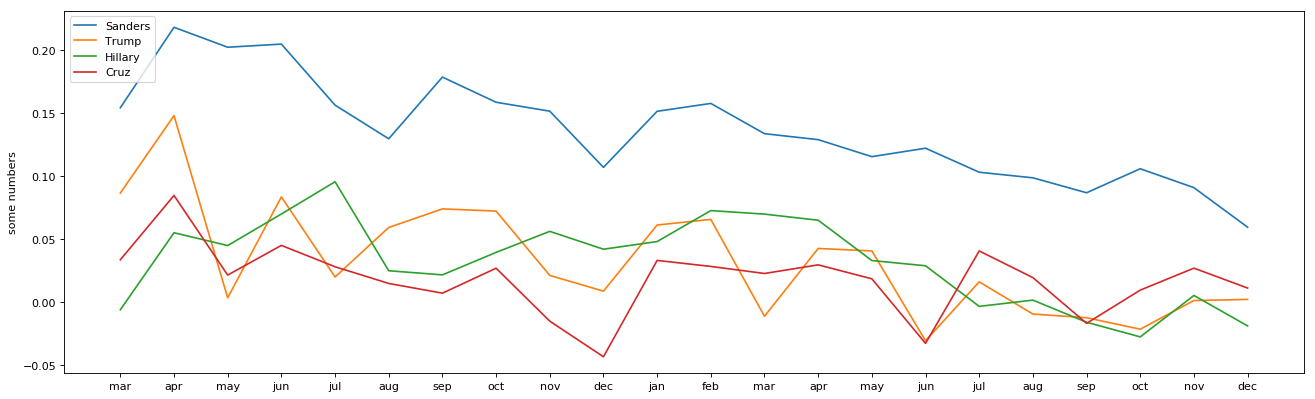

In [5]:
#times = [timeInvert(e[0])[:7] for e in timeTuples]
fig=plt.figure(figsize=(20, 6), dpi= 80, facecolor='w', edgecolor='k')

times = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
x = [e for e in range(len(times))]

plt.xticks(x, times)
plt.plot(meanSanders,label='Sanders')
plt.plot(meanTrump,label='Trump')
plt.plot(meanHillary,label='Hillary')
plt.plot(meanCruz,label='Cruz')
pylab.legend(loc='upper left')

plt.ylabel('some numbers')
plt.show()

# Mess

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
test = pd.DataFrame(commentScores[1])





test2 = test[(test[2] < 1454280854) & (test[2] > 1454279996)]
test2 = test[test[1] > 0.96]

test

In [ ]:
import gensim

doc = "Hey girl. How are you doing? The constitutional crisis of the United States of America is upon us. Trump is a fool, Hillary is a sheep"

gensim.utils.simple_preprocess(doc, deacc=False, min_len=2, max_len=15)


# Timeline

In [12]:
pd.set_option('display.max_colwidth', -1)
with open('articles.json') as f:
    data = json.load(f)


articles = [article for day in data for article in day]
dfTemp = [[article[-1]['num_comments'], article[-1]['created_utc'], timeInvert(article[-1]['created_utc']), article[-1]['title'], article[-1]['url']] for article in articles]

articlesDf = pd.DataFrame(dfTemp)
#newDf = articlesDf[(articlesDf[1] > timeConvert('2015-08-01')) & (articlesDf[1] < timeConvert('2015-09-01'))]

#articlesDf.sort_values(0, ascending=False)
#newDf.sort_values(0, ascending=False)
articlesDf

,0,1,2,3,4
0,68,1425235164,2015-03-01,"TransCanada Is Seizing People’s Land To Build Keystone, But Conservatives Have Been Dead Silent.",http://thinkprogress.org/climate/2015/03/01/3625804/keystone-kelo-eminent-domain-property/
1,76,1425220406,2015-03-01,Why Anti-Pot Congressmen Could Not Stop Marijuana Legalization In The Nation's Capital,http://www.forbes.com/sites/jacobsullum/2015/02/26/why-anti-pot-congressmen-could-not-stop-marijuana-legalization-in-the-nations-capital/
2,87,1425174988,2015-03-01,"But, John Boehner (R-OH) has done it. He cannot do much else, but he has achieved what no other politician could do for half a century: expose the entire Republican national security ""brand"" as a fraud.",http://www.huffingtonpost.com/paul-abrams/boehners-and-bibis-blunders-liberate-us-foreign-policy-from-neocons_b_6775632.html?utm_hp_ref=politics
3,89,1425229334,2015-03-01,The 'War on Women' is the latest war that Republicans at CPAC want to win,http://www.theguardian.com/commentisfree/2015/feb/28/the-war-on-women-at-cpac
4,93,1425235470,2015-03-01,34 Democrats skipping Netanyahu's speech,http://www.cnn.com/2015/02/26/politics/democrats-missing-netanyahu-whip-list/
5,116,1425217869,2015-03-01,"Republican fears grow over court challenge to ObamaCare - ""But the party has begun to fret about the fallout from King v. Burwell, fearing the sudden loss of subsidies could put pressure on lawmakers and governors to restore them.""",http://thehill.com/policy/healthcare/234191-gop-fears-grow-over-obamacare-challenge
6,118,1425239010,2015-03-01,"This is the best explanation of gerrymandering you will ever see - ""How to steal an election: a visual guide""",http://www.washingtonpost.com/blogs/wonkblog/wp/2015/03/01/this-is-the-best-explanation-of-gerrymandering-you-will-ever-see/
7,194,1425206432,2015-03-01,Chris Christie Settles ExxonMobil Case After Oil Giant Gave RGA Big Cash,http://www.ibtimes.com/chris-christie-settles-exxonmobil-case-after-oil-giant-gave-rga-big-cash-1830752#.VPIJHFR7N1M.twitter
8,498,1425223135,2015-03-01,How Scott Walker Built a Career Sending Wisconsin Inmates to Private Prisons,http://www.thenation.com/article/199369/how-scott-walker-built-career-sending-wisconsin-inmates-private-prisons#
9,1201,1425231148,2015-03-01,"Bernie Sanders: “if Hillary Clinton decides to run and I decide to run, we’re going to have very good debates, you know, about the role of Wall Street in our society, about trade policy, about foreign policy—and these are the kinds of debates that absolutely need to take place”",https://www.youtube.com/watch?v=pLxhJqtvfhY


In [ ]:
import matplotlib.dates as dates
import datetime as dt


dates = ['01/02/1991','01/03/1991','01/04/1991']
x = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]
#y = range(len(x)) # many thanks to Kyss Tao for setting me straight here
y = ['a','b','c']




In [ ]:
import pandas as pd
dates = ['2015-12-20','2015-09-12']  
PM_25 = [80, 55]
dates = [pd.to_datetime(d) for d in dates]

plt.scatter(dates, PM_25, s =100, c = 'red')

In [ ]:
import os
from psaw import PushshiftAPI
import time
import datetime
import json
import time
import pprint

# Fetch using psaw
def fetch(sub, af, be):
	api = PushshiftAPI()
	gen =  api.search_submissions(subreddit=sub,
							   #limit=10,
							   after=af,
							   before=be,
							   #,filter=['body','created_utc']
							   )
	return list(gen)

topArticles = []
currDate = 1425164400
day = fetch('politics', str(currDate),str(currDate+24*60*60))

day.sort(key=lambda x: x.num_comments)
print(day[-1][-1]['num_comments'])




In [ ]:
with open('articles.json') as f:
    data = json.load(f)
    


# Sentiments plotted (Hillary, Trump)

In [ ]:
fig=plt.figure(figsize=(20, 6), dpi= 80, facecolor='w', edgecolor='k')

times = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
times = [e[5:7] for e in pollClinTrump['f_dates']]
x = [e for e in range(len(times))]
plt.xticks(x, times)

plt.plot(pollClinTrump['%'].values,label='Clinton')
plt.plot(pollClinTrump['%.1'].values,label='Trump')

pylab.legend(loc='upper left')

plt.ylabel('some numbers')
plt.show()

# Polls

In [4]:
#Load early candidate polls
pollsDf = pd.read_excel('polls.xlsx')

# Add new date formats Epoch and f_dates - Sort by date
dateList = [re.findall(r"[\w']+", e) for e in pollsDf['Date']]
dateList = [' '.join([e[1], e[0]+',', e[-1]]) for e in dateList]
dateList = [datetime.strptime(e, '%d %B, %Y') for e in dateList]
dateList = [e.strftime('%Y-%m-%d') for e in dateList]
pollsDf['f_dates'] = dateList
epochs = [timeConvert(e) for e in pollsDf['f_dates']]
pollsDf['epochs'] = epochs
pollsDf = pollsDf.sort_values(by=['f_dates'])

# Create vs. polls
pollClinTrump = pollsDf[(pollsDf['Democratic candidate'] == 'Hillary Clinton') & (pollsDf['Republican candidate'] == 'Donald Trump')]
pollClinCruz = pollsDf[(pollsDf['Democratic candidate'] == 'Hillary Clinton') & (pollsDf['Republican candidate'] == 'Ted Cruz')]
pollSanTrump =  pollsDf[(pollsDf['Democratic candidate'] == 'Bernie Sanders') & (pollsDf['Republican candidate'] == 'Donald Trump')]
pollSanCruz = pollsDf[(pollsDf['Democratic candidate'] == 'Bernie Sanders') & (pollsDf['Republican candidate'] == 'Ted Cruz')]

In [5]:
# Load later four-way polls
polls_newDf = pd.read_excel('polls_3.xlsx')

# Add new date formats Epoch and f_dates - Sort by date
dateList = [re.findall(r"[\w']+", e) for e in polls_newDf['Date']]
dateList = [' '.join([e[1], e[0]+',', e[-1]]) for e in dateList]
dateList = [datetime.strptime(e, '%d %B, %Y') for e in dateList]
dateList = [e.strftime('%Y-%m-%d') for e in dateList]
polls_newDf['f_dates'] = dateList
epochs = [timeConvert(e) for e in polls_newDf['f_dates']]
polls_newDf['epochs'] = epochs
polls_newDf = polls_newDf.sort_values(by=['f_dates'])




2.8298791540785495

In [6]:


# Monthly mean polls for Clinton and Trump
mClTr = [[np.mean(pollClinTrump[(pollClinTrump['epochs'] > timeConvert(e[0])) & (pollClinTrump['epochs'] < timeConvert(e[1]))]['%']),
         np.mean(pollClinTrump[(pollClinTrump['epochs'] > timeConvert(e[0])) & (pollClinTrump['epochs'] < timeConvert(e[1]))]['%.1']), e[0][:-3]] for e in monthTuples]


# Monthly mean polls for Clinton and Cruz
mClCr = [[np.mean(pollClinCruz[(pollClinCruz['epochs'] > timeConvert(e[0])) & (pollClinCruz['epochs'] < timeConvert(e[1]))]['%']),
         np.mean(pollClinCruz[(pollClinCruz['epochs'] > timeConvert(e[0])) & (pollClinCruz['epochs'] < timeConvert(e[1]))]['%.1']), e[0][:-3]] for e in monthTuples]

# Monthly mean polls for Sanders and Trump
mSaTr = [[np.mean(pollSanTrump[(pollSanTrump['epochs'] > timeConvert(e[0])) & (pollSanTrump['epochs'] < timeConvert(e[1]))]['%']),
         np.mean(pollSanTrump[(pollSanTrump['epochs'] > timeConvert(e[0])) & (pollSanTrump['epochs'] < timeConvert(e[1]))]['%.1']), e[0][:-3]] for e in monthTuples]

    
# Monthly mean polls for Sanders and Cruz
mSaCr = [[np.mean(pollSanCruz[(pollSanCruz['epochs'] > timeConvert(e[0])) & (pollSanCruz['epochs'] < timeConvert(e[1]))]['%']),
         np.mean(pollSanCruz[(pollSanCruz['epochs'] > timeConvert(e[0])) & (pollSanCruz['epochs'] < timeConvert(e[1]))]['%.1']), e[0][:-3]] for e in monthTuples]


# Monthly mean polls for Clinton  Trump in the later stage of the race
late_mClTr = [[np.mean(polls_newDf[(polls_newDf['epochs'] > timeConvert(e[0])) & (polls_newDf['epochs'] < timeConvert(e[1]))]['Hillary Clinton\nDemocratic']),
         np.mean(polls_newDf[(polls_newDf['epochs'] > timeConvert(e[0])) & (polls_newDf['epochs'] < timeConvert(e[1]))]['Donald Trump\nRepublican']), e[0][:-3]] for e in weekTuples]





In [9]:
# Sanders between 2016-02 and 2016-03.
a = pollSanTrump[(pollSanTrump['epochs'] > timeConvert('2016-02-01')) & (pollSanTrump['epochs'] < timeConvert('2016-03-01'))]
a.columns = ['Poll Source','Date','Democratic candidate','p','Republican candidate','p2','Leading by','Sample size','Margin','fdates','epochs']
a.to_latex(index=False)
a


,Poll Source,Date,Democratic candidate,p,Republican candidate,p2,Leading by,Sample size,Margin,fdates,epochs
567,Public Policy Polling,"February 2–3, 2016",Bernie Sanders,0.46,Donald Trump,0.42,4,1.236,NaN,2016-02-02,1.454368e+09
571,Quinnipiac University[397],"February 2–4, 2016",Bernie Sanders,0.49,Donald Trump,0.39,10,1.125,± 2.9%,2016-02-02,1.454368e+09
532,Quinnipiac University[396],"February 10–15, 2016",Bernie Sanders,0.48,Donald Trump,0.42,6,1.342,± 2.7%,2016-02-10,1.455059e+09
544,Suffolk University/USA Today[395],"February 11–15, 2016",Bernie Sanders,0.43,Donald Trump,0.44,1,1,± 3%,2016-02-11,1.455145e+09
550,Fox News[394],"February 15–17, 2016",Bernie Sanders,0.53,Donald Trump,0.38,15,1.031,± 3%,2016-02-15,1.455491e+09
554,CNN/ORC[393],"February 24–27, 2016",Bernie Sanders,0.55,Donald Trump,0.43,12,920,± 3%,2016-02-24,1.456268e+09


In [23]:
polls_newDf

,Poll source,Date,Hillary Clinton Democratic,Donald Trump Republican,Gary Johnson Libertarian,Jill Stein Green,Leading by (points),Sample size,Margin of error,f_dates,epochs
207,Quinnipiac University[633],"May 24–30, 2016",0.40,0.38,0.05,0.03,2,1561.0,±2.5%,2016-05-24,1.464041e+09
152,NBC News[632],"May 30 – June 5, 2016",0.39,0.40,0.09,0.04,1,9240.0,±1.4%,2016-05-30,1.464559e+09
272,Zogby[631],"May 30 – June 5, 2016",0.40,0.34,0.06,0.02,6,837.0,±3.5%,2016-05-30,1.464559e+09
182,NBC/Survey Monkey[339],"June 6–12, 2016",0.42,0.38,0.09,0.05,4,10604.0,±1.3%,2016-06-06,1.465164e+09
249,SurveyUSA[630],"June 8, 2016",0.39,0.36,0.06,0.04,3,1408.0,±2.7%,2016-06-08,1.465337e+09
129,Ipsos/Reuters[629],"June 11–15, 2016",0.39,0.29,0.06,0.04,10,1323.0,±2.8%,2016-06-11,1.465596e+09
173,NBC News/SurveyMonkey[332],"June 13–19, 2016",0.42,0.38,0.09,0.05,4,16135.0,±1.1%,2016-06-13,1.465769e+09
140,Monmouth University[331],"June 15–19, 2016",0.42,0.36,0.09,0.04,6,803.0,±3.5%,2016-06-15,1.465942e+09
45,CNN/ORC[330],"June 16–19, 2016",0.42,0.38,0.09,0.07,4,891.0,±3.5%,2016-06-16,1.466028e+09
128,Ipsos/Reuters[325],"June 18–22, 2016",0.43,0.34,0.06,0.05,9,1339.0,±2.8%,2016-06-18,1.466201e+09


# 1. Hillary vs. Trump - subplots

<Figure size 1600x480 with 0 Axes>

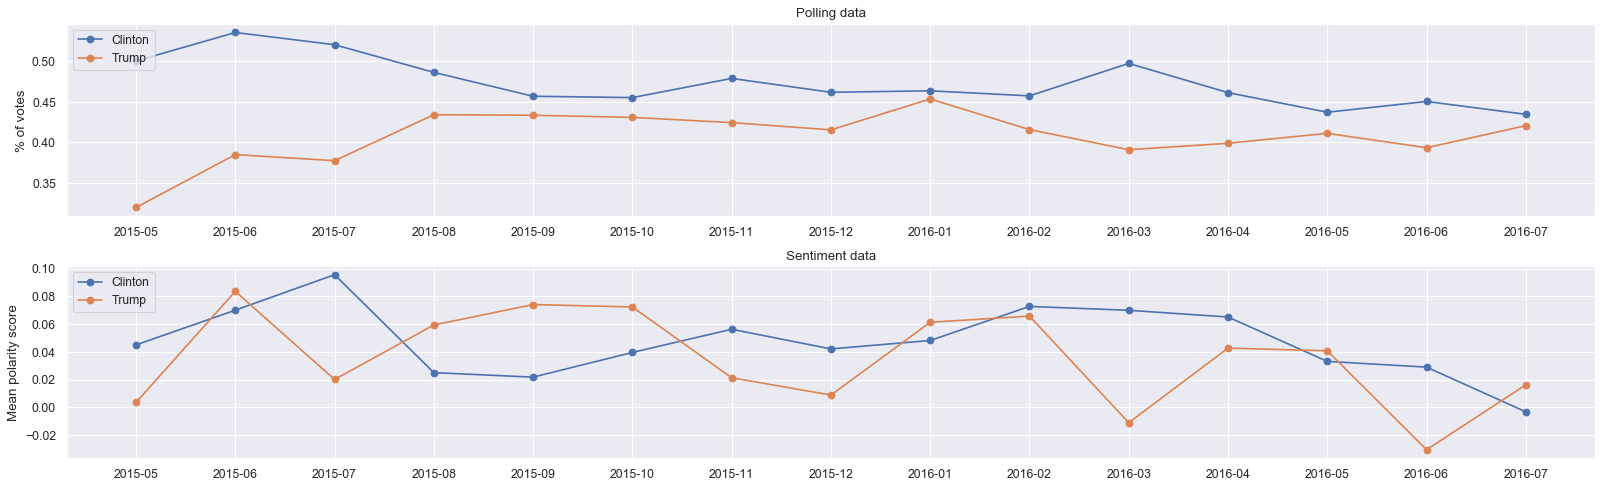

In [102]:
#times = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

# Define x axis
times = [e[2] for e in mClTr[2:17]]
x = [e for e in range(len(times))]

# Mean polling for Hillary and Trump, monthly
pHillary = [e[0] for e in mClTr][2:17]
pTrump = [e[1] for e in mClTr][2:17]

# Mean sentiment for Hillary and Trump, monthly
sHillary = meanHillary[2:17]
sTrump = meanTrump[2:17]

# Normalized mean poll
npHillary = preprocessing.normalize([pHillary])[0]
npTrump = preprocessing.normalize([pTrump])[0]

# Normalized mean sentiment
nsHillary = preprocessing.normalize([sHillary])[0]
nsTrump = preprocessing.normalize([sTrump])[0]

# Plot
fig=plt.figure(figsize=(18 6), dpi= 80, facecolor='w', edgecolor='k')
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(18 6), dpi= 80, facecolor='w', edgecolor='k')
plt.setp(axs, xticks=x, xticklabels=times)

# Subplot 1
axs[0].title.set_text('Polling data')
axs[0].plot(pHillary,label='Clinton', linestyle='-', marker='o')
axs[0].plot(pTrump,label='Trump', linestyle='-', marker='o')
axs[0].legend(loc='upper left')


# y-Labels
axs[0].set_ylabel('% of votes')
axs[1].set_ylabel('Mean polarity score')

axs[1].title.set_text('Sentiment data')
axs[1].plot(sHillary,label='Clinton', linestyle='-', marker='o')
axs[1].plot(sTrump,label='Trump', linestyle='-', marker='o')
axs[1].legend(loc='upper left')



# 2. Hillary vs. Cruz - subplots

<Figure size 1440x480 with 0 Axes>

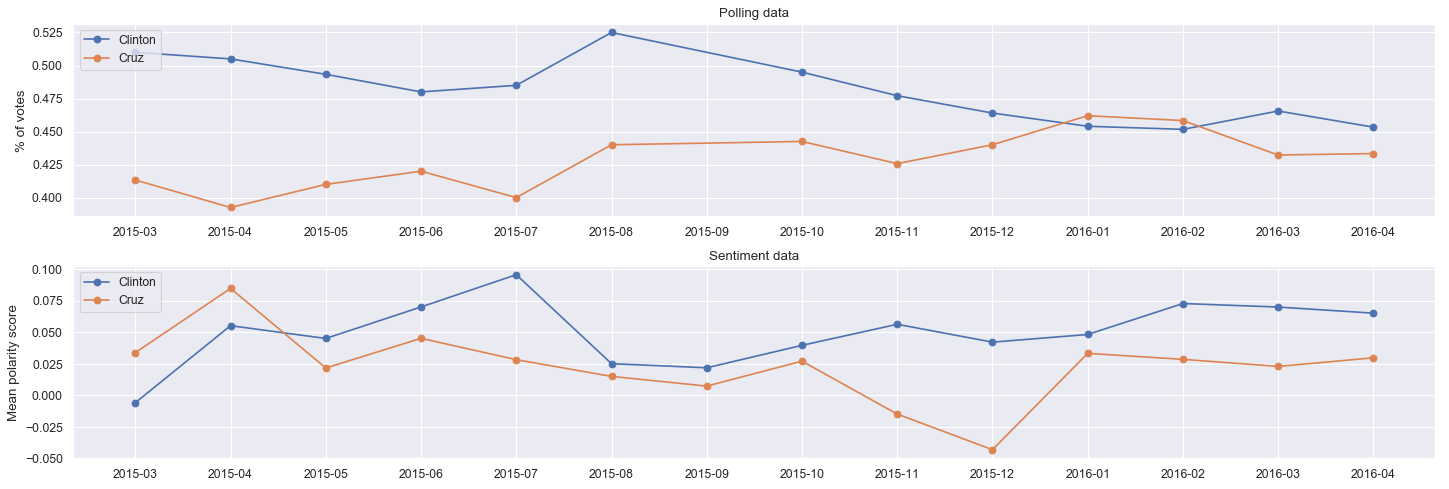

In [109]:
# No Polling data for september 2015 for Cruz, Clinton
# Define x axis
times = [e[2] for e in mClCr[:-8]]
x = np.array([e for e in range(len(times))])

# Mean polling for Hillary and Trump, monthly
pHillary = np.array([e[0] for e in mClCr][:-8]).astype(np.double)
pCruz = [e[1] for e in mClCr][:-8]

pHmask = np.isfinite(pHillary)
pCmask = np.isfinite(pCruz)

# Mean sentiment for Hillary and Cruz, monthly
sHillary = meanHillary[:-8]
sCruz = meanCruz[:-8]

# Normalized mean poll
#npHillary = preprocessing.normalize([pHillary])[0]
#npCruz = preprocessing.normalize([pCruz])[0]

# Normalized mean sentiment
#nsHillary = preprocessing.normalize([sHillary])[0]
#nsCruz = preprocessing.normalize([sCruz])[0]

# Plot
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.setp(axs, xticks=x, xticklabels=times)


# Subplot 1
axs[0].title.set_text('Polling data')
series1 = np.array(pHillary).astype(np.double)
s1mask = np.isfinite(series1)
series2 = np.array(pCruz).astype(np.double)
s2mask = np.isfinite(series1)
axs[0].plot(x[s1mask], series1[s1mask], label='Clinton', linestyle='-', marker='o')
axs[0].plot(x[s2mask], series2[s2mask], label='Cruz', linestyle='-', marker='o')
axs[0].legend(loc='upper left')

# y-Labels
axs[0].set_ylabel('% of votes')
axs[1].set_ylabel('Mean polarity score')

# Subplot 2
axs[1].title.set_text('Sentiment data')
axs[1].plot(sHillary,label='Clinton', linestyle='-', marker='o')
axs[1].plot(sCruz,label='Cruz', linestyle='-', marker='o')
axs[1].legend(loc='upper left')


# 3. Sanders vs. Trump - subplots

<Figure size 1600x480 with 0 Axes>

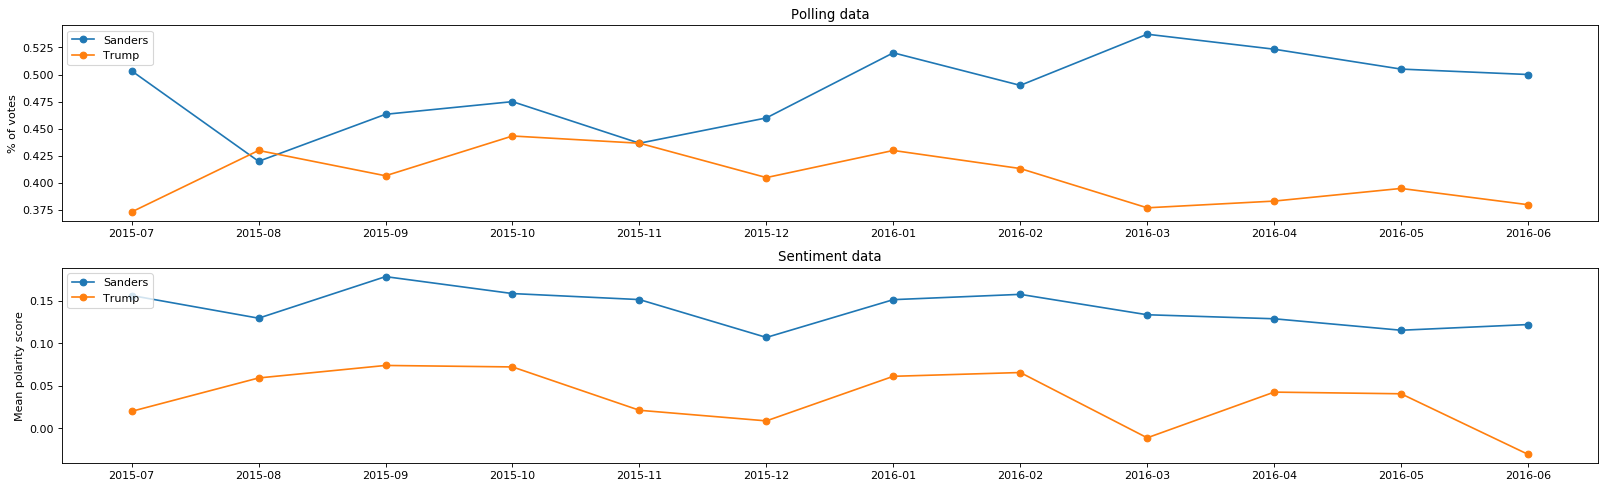

In [44]:
# Define x axis
times = [e[2] for e in mSaTr[4:16]]
x = [e for e in range(len(times))]

# Mean polling for Hillary and Trump, monthly
pSanders = [e[0] for e in mSaTr[4:16]]
pTrump = [e[1] for e in mSaTr[4:16]]

# Mean sentiment for Hillary and Trump, monthly
sSanders = meanSanders[4:16]
sTrump = meanTrump[4:16]

# Normalized mean poll
#npHillary = preprocessing.normalize([pHillary])[0]
#npTrump = preprocessing.normalize([pTrump])[0]

# Normalized mean sentiment
#nsHillary = preprocessing.normalize([sHillary])[0]
#nsTrump = preprocessing.normalize([sTrump])[0]

# Plot
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.setp(axs, xticks=x, xticklabels=times)

# Subplot 1
axs[0].title.set_text('Polling data')
axs[0].plot(pSanders,label='Sanders', linestyle='-', marker='o')
axs[0].plot(pTrump,label='Trump', linestyle='-', marker='o')
axs[0].legend(loc='upper left')

# y-Labels
axs[0].set_ylabel('% of votes')
axs[1].set_ylabel('Mean polarity score')

# Subplot 2
axs[1].title.set_text('Sentiment data')
axs[1].plot(sSanders,label='Sanders', linestyle='-', marker='o')
axs[1].plot(sTrump,label='Trump', linestyle='-', marker='o')
axs[1].legend(loc='upper left')


# 4. Sanders vs. Cruz - subplots

<Figure size 1600x480 with 0 Axes>

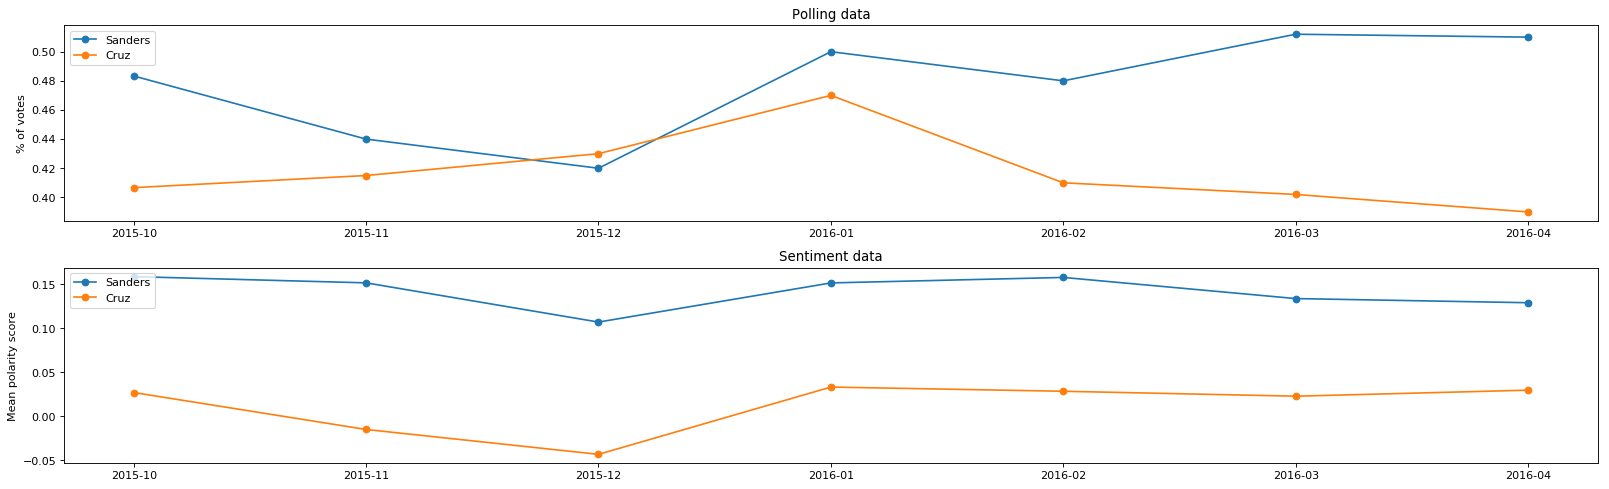

In [44]:
# Define x axis
times = [e[2] for e in mSaCr[7:14]]
x = [e for e in range(len(times))]

# Mean polling for Hillary and Trump, monthly
pSanders = [e[0] for e in mSaCr[7:14]]
pCruz = [e[1] for e in mSaCr[7:14]]

# Mean sentiment for Hillary and Trump, monthly
sSanders = meanSanders[7:14]
sCruz = meanCruz[7:14]

# Normalized mean poll
#npHillary = preprocessing.normalize([pHillary])[0]
#npTrump = preprocessing.normalize([pTrump])[0]

# Normalized mean sentiment
#nsHillary = preprocessing.normalize([sHillary])[0]
#nsTrump = preprocessing.normalize([sTrump])[0]

# Plot
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.setp(axs, xticks=x, xticklabels=times)

# Subplot 1
axs[0].title.set_text('Polling data')
axs[0].plot(pSanders,label='Sanders', linestyle='-', marker='o')
axs[0].plot(pCruz,label='Cruz', linestyle='-', marker='o')
axs[0].legend(loc='upper left')

# y-Labels
axs[0].set_ylabel('% of votes')
axs[1].set_ylabel('Mean polarity score')


# Subplot 2
axs[1].title.set_text('Sentiment data')
axs[1].plot(sSanders,label='Sanders', linestyle='-', marker='o')
axs[1].plot(sCruz,label='Cruz', linestyle='-', marker='o')
axs[1].legend(loc='upper left')


# 5. Clinton vs. Trump - Late race

24


<Figure size 1600x480 with 0 Axes>

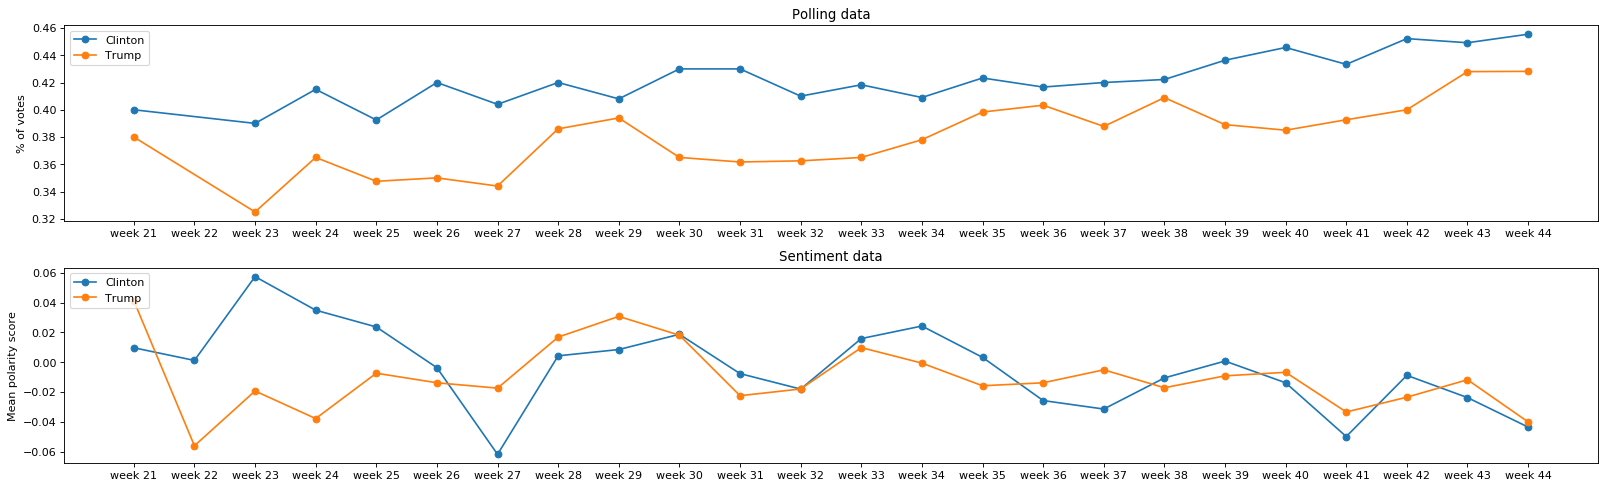

In [59]:
# Define x axis
times = [e[2] for e in late_mClTr[:-8]]
weeks = ['week '+str(i) for i in range(21,(21+len(times)))]
times = weeks
x = np.array([e for e in range(len(times))])

# Mean polling for Hillary and Trump, monthly
pHillary = [e[0] for e in late_mClTr[:-8]]
pTrump = [e[1] for e in late_mClTr[:-8]]

# Mean sentiment for Hillary and Trump, monthly
sHillary = wmeanHillary[:-8]
sTrump = wmeanTrump[:-8]


# Plot
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.setp(axs, xticks=x, xticklabels=times)

# Subplot 1
axs[0].title.set_text('Polling data')
series1 = np.array(pHillary).astype(np.double)
s1mask = np.isfinite(series1)
series2 = np.array(pTrump).astype(np.double)
s2mask = np.isfinite(series1)
axs[0].plot(x[s1mask], series1[s1mask], label='Clinton', linestyle='-', marker='o')
axs[0].plot(x[s2mask], series2[s2mask], label='Trump', linestyle='-', marker='o')
axs[0].legend(loc='upper left')

# y-Labels
axs[0].set_ylabel('% of votes')
axs[1].set_ylabel('Mean polarity score')


# Subplot 2
axs[1].title.set_text('Sentiment data')
axs[1].plot(sHillary,label='Clinton', linestyle='-', marker='o')
axs[1].plot(sTrump,label='Trump', linestyle='-', marker='o')
axs[1].legend(loc='upper left')

print(len(weeks))


# Single plot (poll and sentiment)

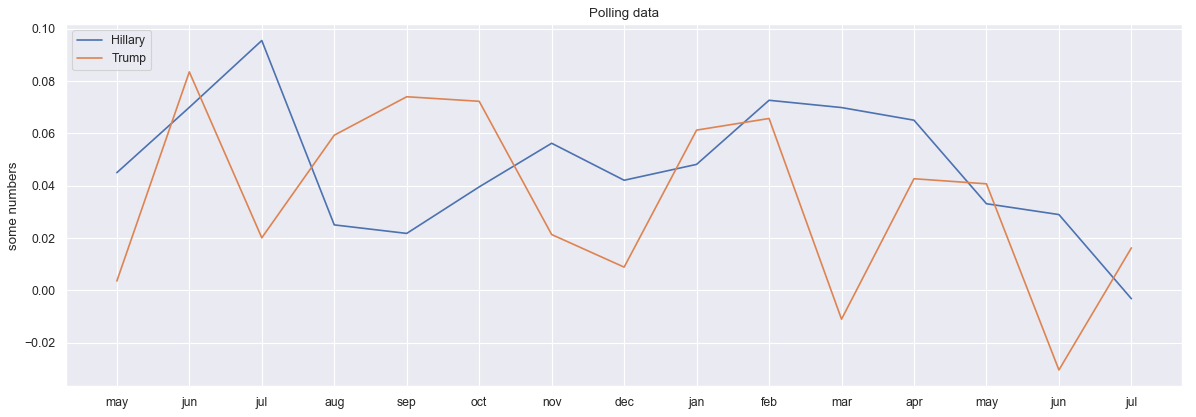

In [110]:
#times = [timeInvert(e[0])[:7] for e in timeTuples]
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

times = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
times = times[2:17]
x = [e for e in range(len(times))]

plt.xticks(x, times)

scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform([meanTrump[2:17],[e[1] for e in mClTr][2:17]])


mHillary = meanHillary[2:17]
mTrump = meanTrump[2:17]

sHillary = [e[0] for e in mClTr][2:17]
sTrump = [e[1] for e in mClTr][2:17]

nmHillary = preprocessing.normalize([mHillary])[0]
nmTrump = preprocessing.normalize([mTrump])[0]

nsHillary = preprocessing.normalize([sHillary])[0]
nsTrump = preprocessing.normalize([sTrump])[0]
#b = preprocessing.normalize([meanTrump[2:17]])[0]
#c = preprocessing.normalize([[e[1] for e in mClTr][2:17]])[0]



plt.plot(mHillary,label='Hillary')
plt.plot(mTrump,label='Trump')



pylab.legend(loc='upper left')
plt.title('Polling data')
plt.ylabel('some numbers')
plt.show()

# General data analysis (comments per month, polls per month)

In [64]:
stats.linregress(pClCrCl,sClCrCl)

#stats.linregress(pClCrCr,sClCrCr)

LinregressResult(slope=-0.5876162502664267, intercept=0.33510681264694253, rvalue=-0.5494087569340267, pvalue=0.05179208325948408, stderr=0.26944880035064156)

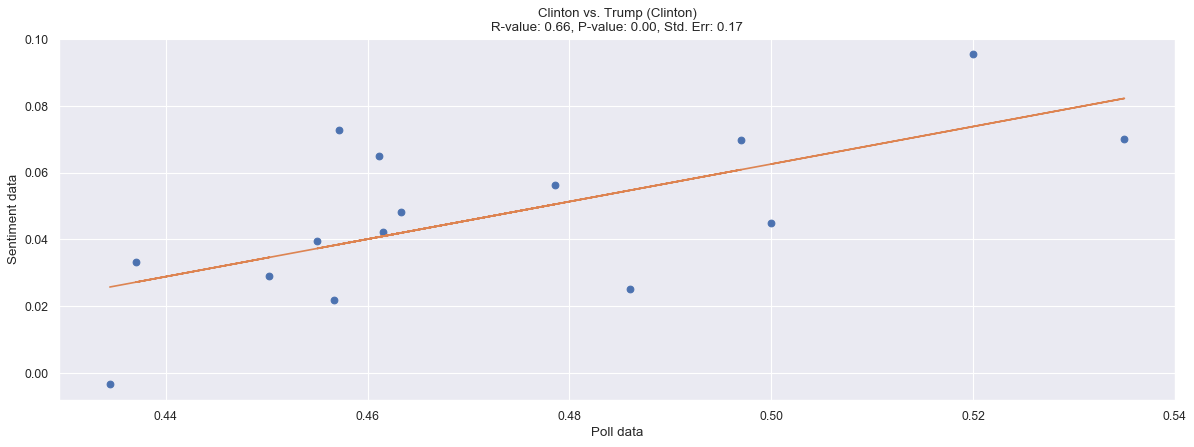

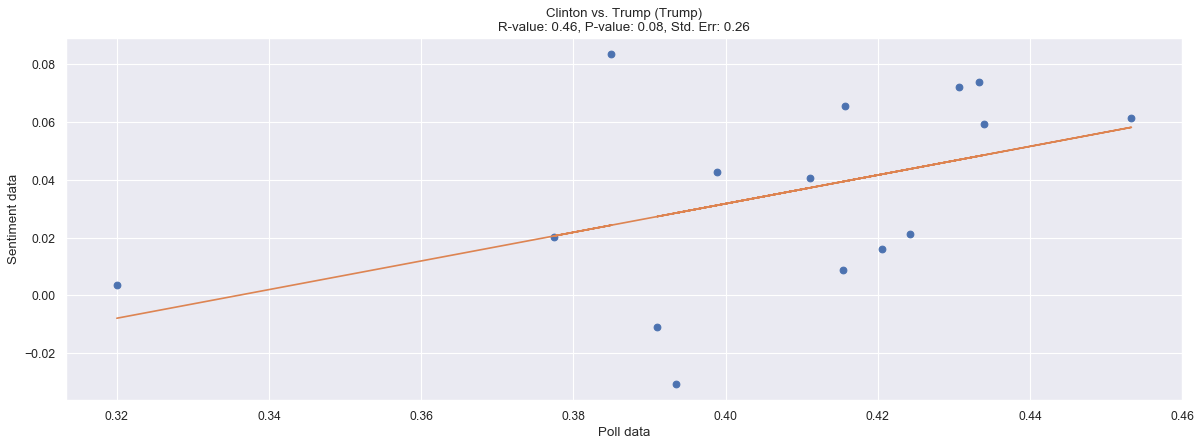

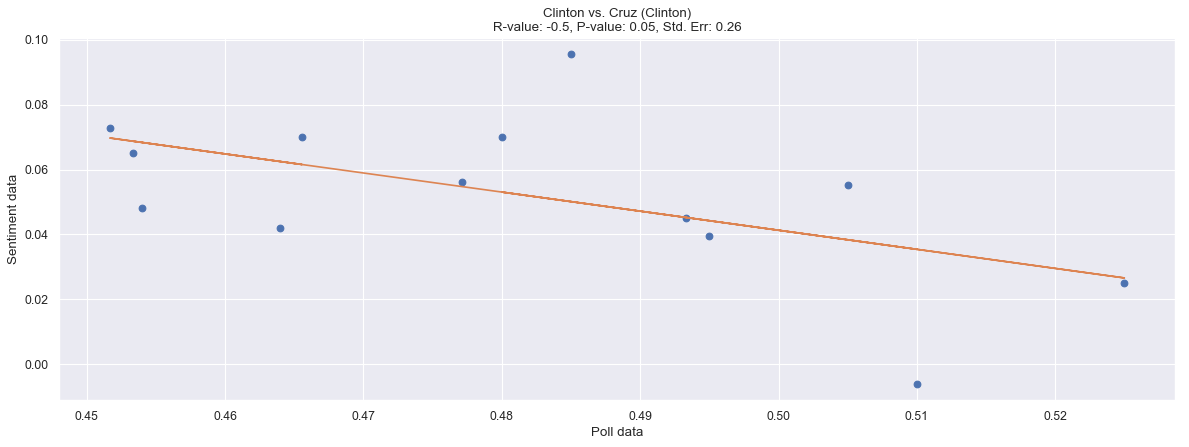

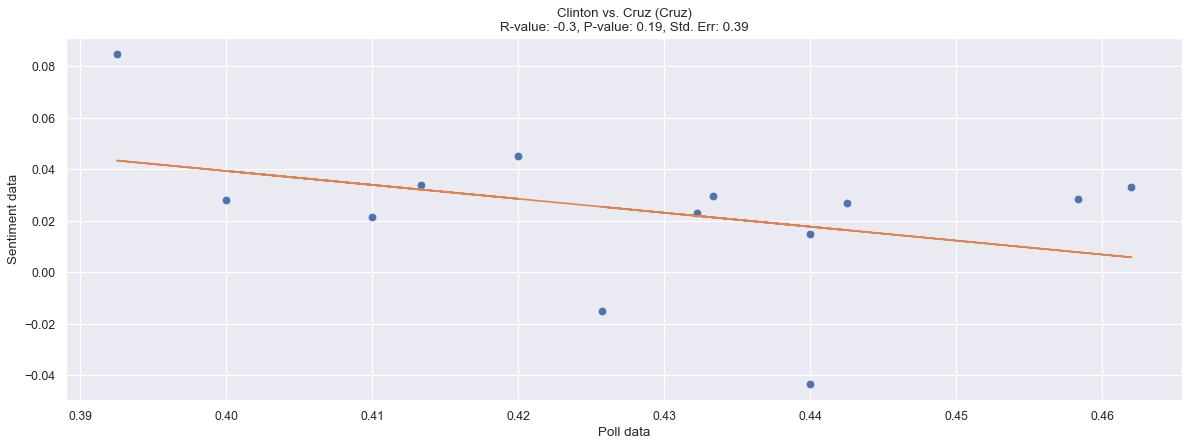

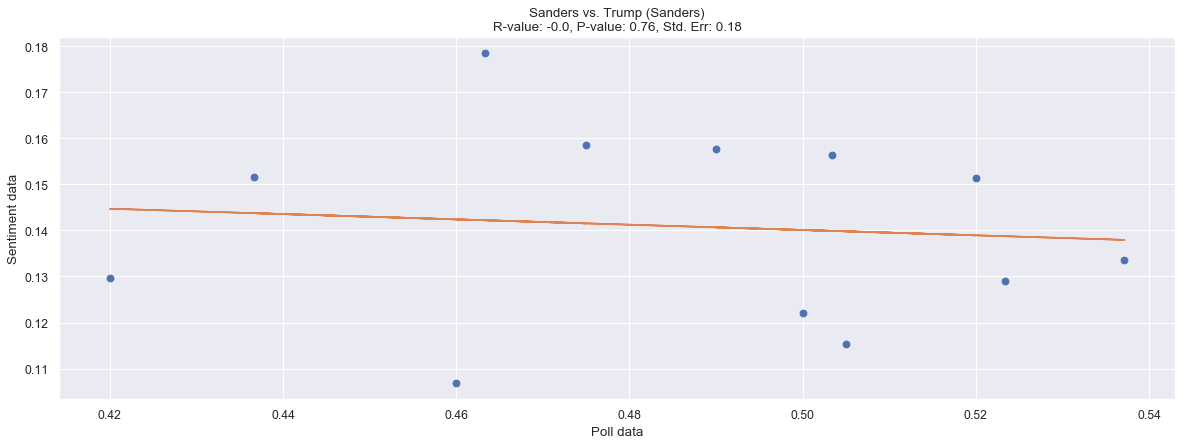

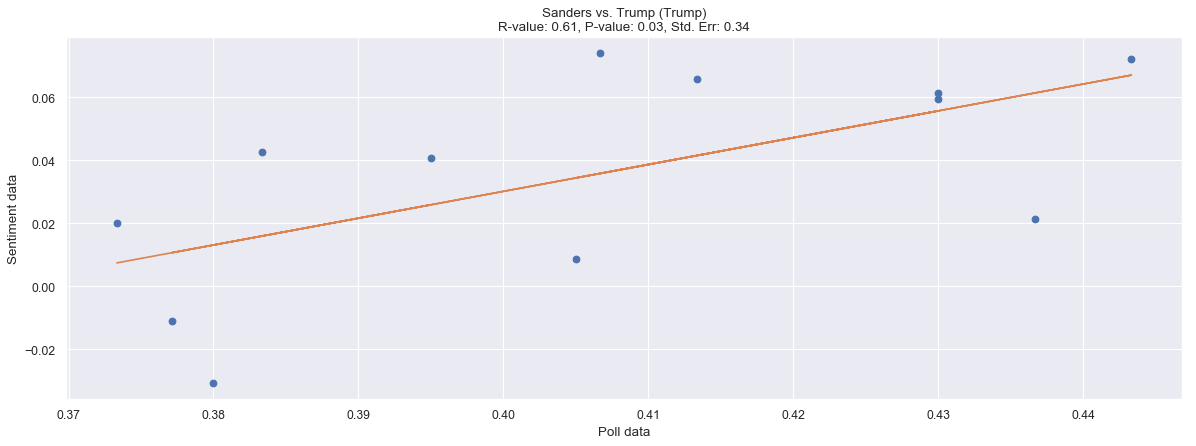

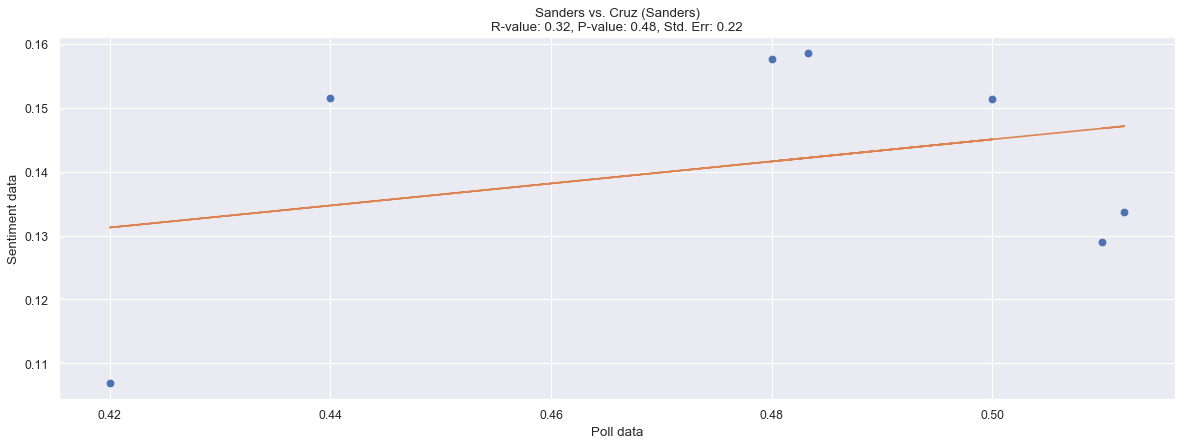

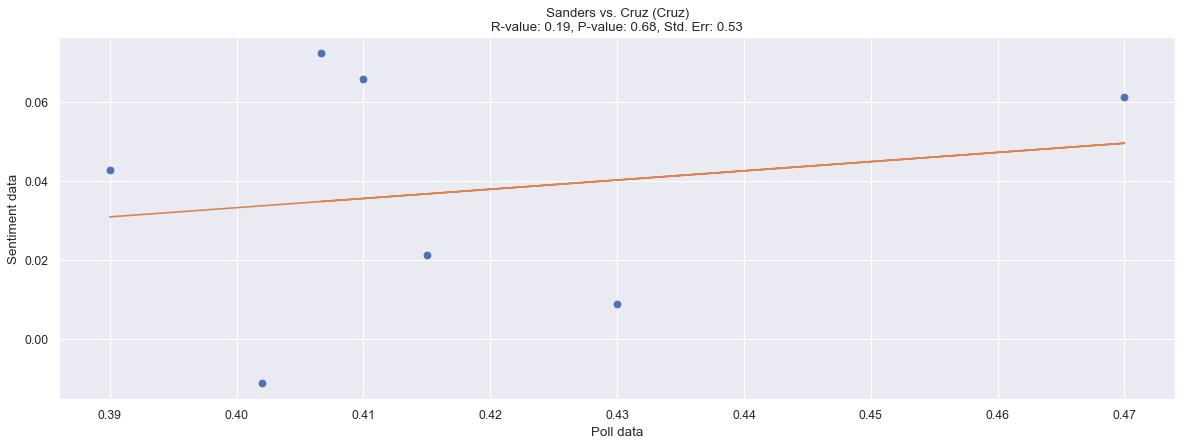

In [201]:
# Linear regression plots

# ClinTrump
pClTrCl = [e[0] for e in mClTr][2:17]
pClTrTr = [e[1] for e in mClTr][2:17]
sClTrCl = meanHillary[2:17]
sClTrTr = meanTrump[2:17]


# ClinCruz
pClCrCl = np.delete(np.array([e[0] for e in mClCr][:-8]).astype(np.double), 6)
pClCrCr = np.delete([e[1] for e in mClCr][:-8],6)
sClCrCl = np.delete(meanHillary[:-8], 6)
sClCrCr = np.delete(meanCruz[:-8], 6)

# Mean polling for Hillary and Trump, monthly
pSaTrSa = [e[0] for e in mSaTr[4:16]]
pSaTrTr = [e[1] for e in mSaTr[4:16]]
sSaTrSa = meanSanders[4:16]
sSaTrTr = meanTrump[4:16]

# SanCruz
pSaCrSa = [e[0] for e in mSaCr[7:14]]
pSaCrCr = [e[1] for e in mSaCr[7:14]]
sSaCrSa = meanSanders[7:14]
sSaCrCr = meanTrump[7:14]


canList = [[pClTrCl,sClTrCl,'Clinton vs. Trump (Clinton)'],[pClTrTr,sClTrTr,'Clinton vs. Trump (Trump)'],
           [pClCrCl,sClCrCl,'Clinton vs. Cruz (Clinton)'], [pClCrCr,sClCrCr,'Clinton vs. Cruz (Cruz)'],
          [pSaTrSa,sSaTrSa,'Sanders vs. Trump (Sanders)'], [pSaTrTr,sSaTrTr,'Sanders vs. Trump (Trump)'],
           [pSaCrSa,sSaCrSa,'Sanders vs. Cruz (Sanders)'], [pSaCrCr,sSaCrCr,'Sanders vs. Cruz (Cruz)']]

for candidate in canList:
    # Generated linear fit
    xi = np.array(candidate[0])
    y = np.array(candidate[1])

    slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)

    line = slope*xi+intercept

    fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
    fig = plt.plot(xi,y,'o', xi, line)
    plt.xlabel('Poll data')
    plt.ylabel('Sentiment data')
    r_value = str(r_value)[:4]
    p_value = str(p_value)[:4]
    std_err = str(std_err)[:4]
    
    plt.title((candidate[2]+'\nR-value: '+r_value+', P-value: '+p_value+', Std. Err: '+std_err))
    ax = plt.gca()


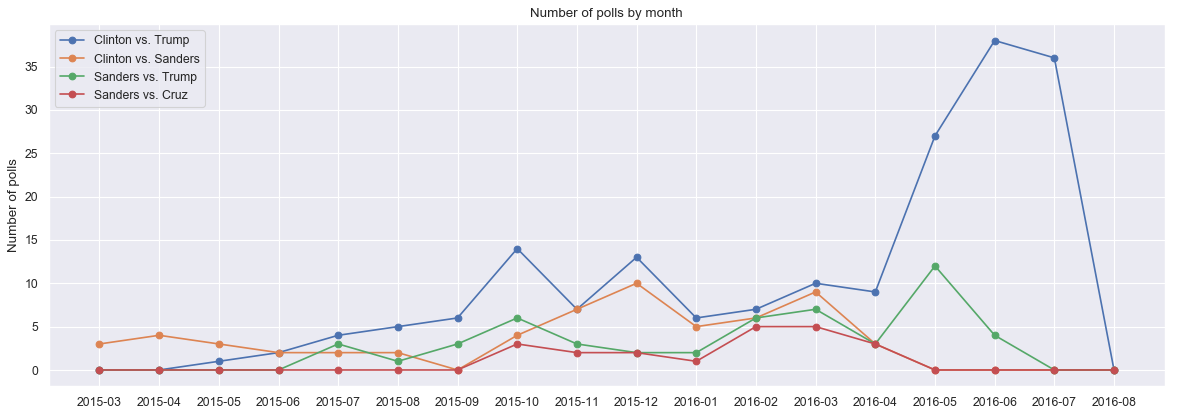

[0, 0, 0, 0, 3, 1, 3, 6, 3, 2, 2, 6, 7, 3, 12, 4, 0, 0, 0, 0, 0, 0]

In [103]:
# Number of polls

noPolls_clTr = [len(pollClinTrump[(pollClinTrump['epochs'] > timeConvert(e[0])) & (pollClinTrump['epochs'] < timeConvert(e[1]))]['%']) for e in monthTuples]
noPolls_clCr = [len(pollClinCruz[(pollClinCruz['epochs'] > timeConvert(e[0])) & (pollClinCruz['epochs'] < timeConvert(e[1]))]['%']) for e in monthTuples]
noPolls_SaTr = [len(pollSanTrump[(pollSanTrump['epochs'] > timeConvert(e[0])) & (pollSanTrump['epochs'] < timeConvert(e[1]))]['%']) for e in monthTuples]
noPolls_SaCr = [len(pollSanCruz[(pollSanCruz['epochs'] > timeConvert(e[0])) & (pollSanCruz['epochs'] < timeConvert(e[1]))]['%']) for e in monthTuples]

fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

times = [e[0][:7] for e in monthTuples]
x = [e for e in range(len(timeTuples))]
plt.xticks(x[:-4], times[:-4])

plt.plot(noPolls_clTr[:-4],label='Clinton vs. Trump', linestyle='-', marker='o')
plt.plot(noPolls_clCr[:-4],label='Clinton vs. Cruz', linestyle='-', marker='o')
plt.plot(noPolls_SaTr[:-4],label='Sanders vs. Trump', linestyle='-', marker='o')
plt.plot(noPolls_SaCr[:-4],label='Sanders vs. Cruz', linestyle='-', marker='o')



pylab.legend(loc='upper left')
plt.title('Number of polls by month')
plt.ylabel('Number of polls')
plt.show()

noPolls_SaTr

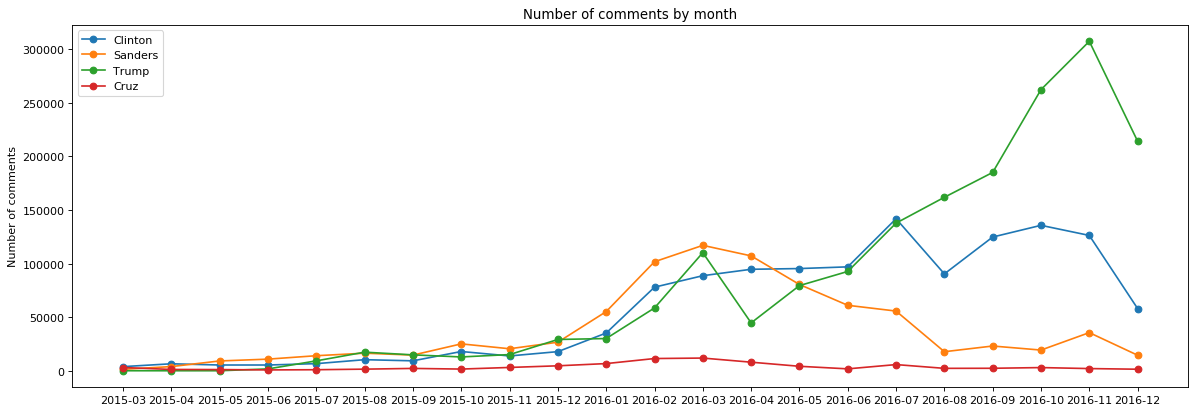

In [27]:
# Comments per month for each candidate

sumHillary = [len(hillaryScores[(hillaryScores[2] > e[0]) & (hillaryScores[2] < e[1])][1]) for e in timeTuples]
sumCruz = [len(cruzScores[(cruzScores[2] > e[0]) & (cruzScores[2] < e[1])][1]) for e in timeTuples]
sumTrump = [len(trumpScores[(trumpScores[2] > e[0]) & (trumpScores[2] < e[1])][1]) for e in timeTuples]
sumSanders = [len(sandersScores[(sandersScores[2] > e[0]) & (sandersScores[2] < e[1])][1]) for e in timeTuples]





fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

times = [e[0][:7] for e in monthTuples]
x = [e for e in range(len(timeTuples))]
plt.xticks(x, times)

plt.plot(sumHillary,label='Clinton', linestyle='-', marker='o')
plt.plot(sumSanders,label='Sanders', linestyle='-', marker='o')
plt.plot(sumTrump,label='Trump', linestyle='-', marker='o')
plt.plot(sumCruz,label='Cruz', linestyle='-', marker='o')

sumCruz
sumSanders

pylab.legend(loc='upper left')
plt.title('Number of comments by month')
plt.ylabel('Number of comments')
plt.show()

In [1]:
[sum(noPolls_clTr), sum(noPolls_clCr), sum(noPolls_SaTr), sum(noPolls_SaCr)]

NameError: name 'noPolls_clTr' is not defined

# Correlations

In [28]:
[e for e in mSaTr[4:16]]


[[0.5033333333333333, 0.37333333333333335, '2015-07'],
 [0.42, 0.43, '2015-08'],
 [0.4633333333333334, 0.4066666666666667, '2015-09'],
 [0.4749999999999999, 0.44333333333333336, '2015-10'],
 [0.4366666666666667, 0.4366666666666667, '2015-11'],
 [0.45999999999999996, 0.405, '2015-12'],
 [0.52, 0.43, '2016-01'],
 [0.48999999999999994, 0.41333333333333333, '2016-02'],
 [0.537142857142857, 0.3771428571428571, '2016-03'],
 [0.5233333333333333, 0.3833333333333333, '2016-04'],
 [0.505, 0.395, '2016-05'],
 [0.5, 0.38, '2016-06']]

In [17]:

from scipy.stats import linregress

clTr_clin = [[e[0] for e in mClTr[2:17]], meanHillary[2:17]]
clTr_trum = [[e[1] for e in mClTr[2:17]], meanTrump[2:17]]

clCr_clin = [[e[0] for e in mClCr[:-8]], meanHillary[:-8]]
clCr_cruz = [[e[1] for e in mClCr[:-8]], meanCruz[:-8]]

saTr_sand = [[e[0] for e in mSaTr[4:16]], meanSanders[4:16]]
saTr_trum = [[e[1] for e in mSaTr[4:16]], meanTrump[4:16]]

saCr_sand = [[e[0] for e in mSaCr[7:14]], meanSanders[7:14]]
saCr_cruz = [[e[1] for e in mSaCr[7:14]], meanCruz[7:14]]

wClTr_cli = [[e[0] for e in late_mClTr[2:-8]], wmeanHillary[2:-8]]
wClTr_tru  = [[e[1] for e in late_mClTr[2:-8]], wmeanTrump[2:-8]]

#print('Clinton vs. Trump, Clinton:', linregress(clTr_clin))
#print('Clinton vs. Trump, Trump:', linregress(clTr_trum))
#
#print('Clinton vs. Cruz, Clinton:', linregress(clCr_clin))
#print('Clinton vs. Cruz, Cruz:', linregress(clCr_cruz))
#
#print('Sanders vs. Trump, Sanders:', linregress(saTr_sand))
#print('Sanders vs. Trump, Trump:', linregress(saTr_trum))
#
#print('Sanders vs. Cruz, Sanders:', linregress(saCr_sand))
#print('Sanders vs. Cruz, Cruz:', linregress(saCr_cruz))
#
#print('Clinton vs. Trump (late), Clinton:', linregress(wClTr_cli))
#print('Clinton vs. Trump (late), Trump:', linregress(wClTr_tru))


name_data = ['Clinton vs. Trump, Clinton', 'Clinton vs. Trump, Trump', 'Clinton vs. Cruz, Clinton', 'Clinton vs. Cruz, Cruz', 'Sanders vs. Trump, Sanders', 
             'Sanders vs. Trump, Trump', 'Sanders vs. Cruz, Sanders', 'Sanders vs. Cruz, Cruz', 'Clinton vs. Trump (late), Clinton', 'Clinton vs. Trump (late), Trump']
corr_data = [clTr_clin, clTr_trum, clCr_clin,clCr_cruz, saTr_sand, saTr_trum, saCr_sand, saCr_cruz, wClTr_cli, wClTr_tru]

for i, e in enumerate(corr_data):
    print(name_data[i], linregress(e))
# Tyder på moderat linear sammenhæng 


linregress(wClTr_cli)

Clinton vs. Trump, Clinton LinregressResult(slope=0.5623829103200941, intercept=-0.21861335722146646, rvalue=0.6612332139878483, pvalue=0.007268346318112893, stderr=0.17695852645802537)
Clinton vs. Trump, Trump LinregressResult(slope=0.49558528362482435, intercept=-0.16647406215270605, rvalue=0.46078646521972777, pvalue=0.08387855438318433, stderr=0.2647407360630037)
Clinton vs. Cruz, Clinton LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan)
Clinton vs. Cruz, Cruz LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan)
Sanders vs. Trump, Sanders LinregressResult(slope=-0.05768295063753619, intercept=0.16892842132834265, rvalue=-0.0975931840332829, pvalue=0.7628532331466035, stderr=0.18601581289842592)
Sanders vs. Trump, Trump LinregressResult(slope=0.851093884415673, intercept=-0.3102758141736955, rvalue=0.6197337356012396, pvalue=0.031602386339768106, stderr=0.34083018086903766)
Sanders vs. Cruz, Sanders LinregressResult(slope=0.1725

C:\Users\dan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\dan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\dan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


LinregressResult(slope=-0.7285774872878853, intercept=0.30317286436030777, rvalue=-0.4539181172964777, pvalue=0.03383913490409114, stderr=0.3198026741341601)

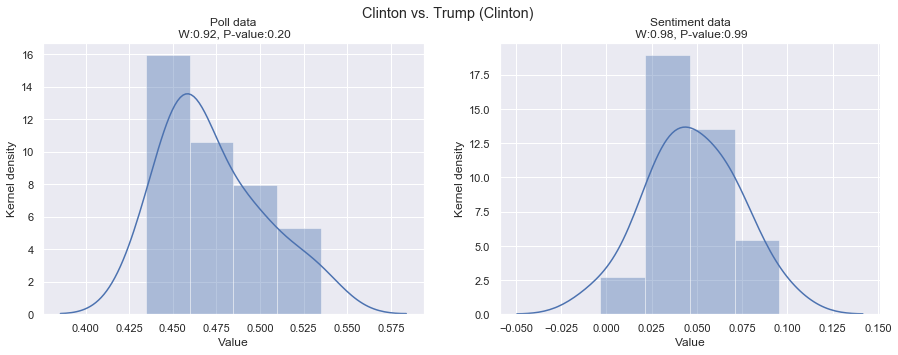

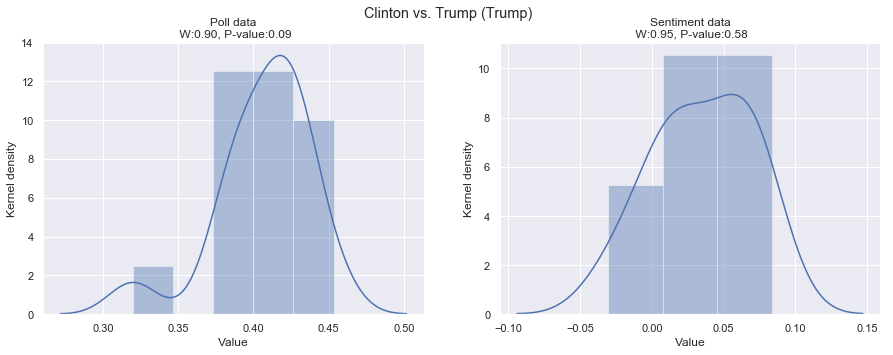

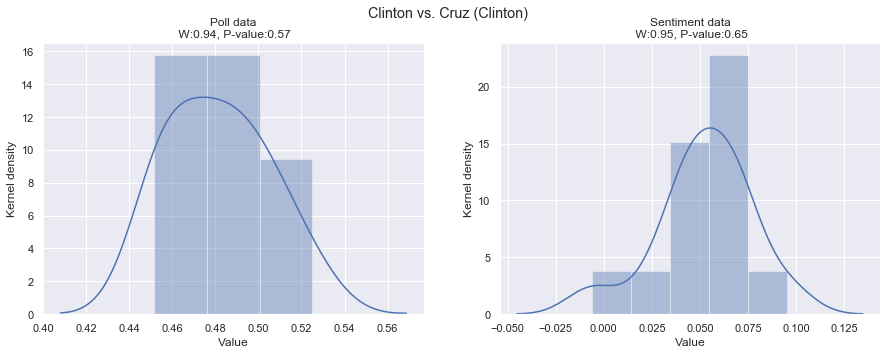

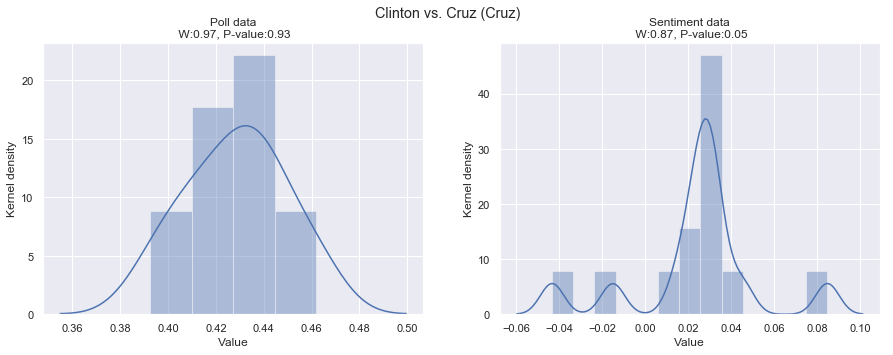

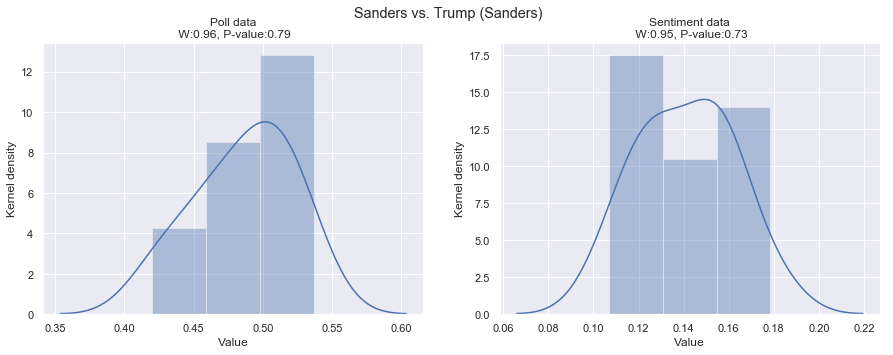

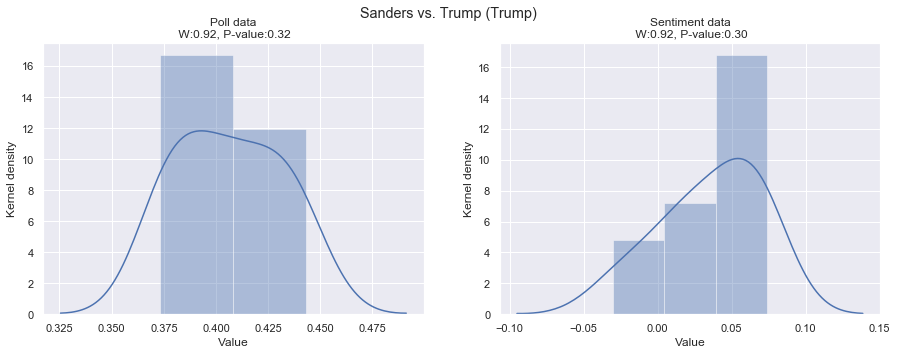

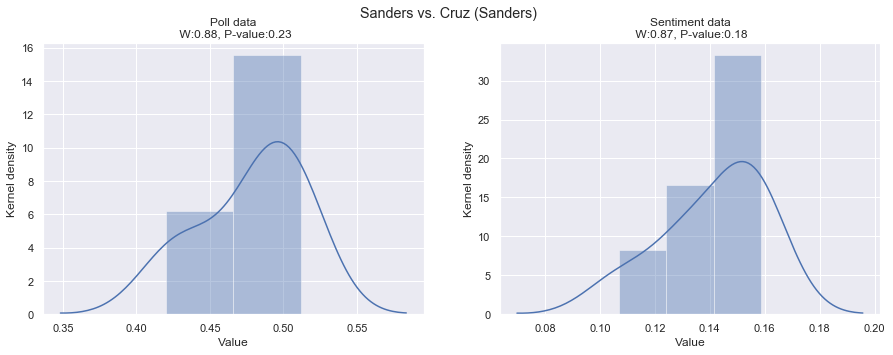

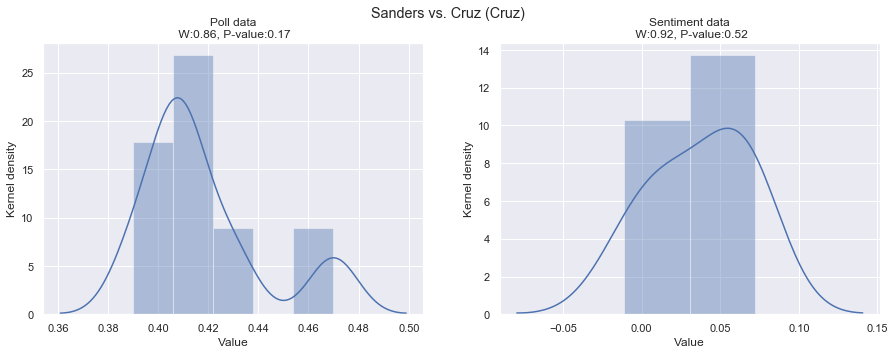

KeyError: 'text.fontsize is not a valid rc parameter. See rcParams.keys() for a list of valid parameters.'

In [205]:
# Shapiro Wilk Test for normality

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)


x = pSaCrSa

for candidate in canList:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    plt.suptitle(candidate[2])
    
    W, p = stats.shapiro(candidate[0])
    W = str(W)[:4]
    p = str(p)[:4]
    
    sns.distplot(candidate[0], ax=axes[0])
    sns.distplot(candidate[1], ax=axes[1])

    axes[0].set_title(('Poll data\n W:'+ W+ ', P-value:'+p))
    axes[0].set_xlabel("Value")
    axes[0].set_ylabel("Kernel density")

    
    W, p = stats.shapiro(candidate[1])
    W = str(W)[:4]
    p = str(p)[:4]
    
    axes[1].set_title(('Sentiment data\n W:'+ W+ ', P-value:'+p))
    axes[1].set_xlabel("Value")
    axes[1].set_ylabel("Kernel density")

    plt.show(fig)



In [157]:

df = pd.DataFrame(saTr_sand[0])
df[1] = saTr_sand[1]

# Create the Scaler object
scaler = preprocessing.MinMaxScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(df)
#scaled_df = pd.DataFrame(scaled_df, columns=names)

pd.DataFrame(scaled_df)

#times = [timeInvert(e[0])[:7] for e in timeTuples]
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

times = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
times = times[2:17]
x = [e for e in range(len(times))]

plt.xticks(x, times)

plt.plot(df[0],label='Trump polls')
plt.plot(df[1],label='Trump Sentiment')

pylab.legend(loc='upper left')
plt.title('Standard Scaling')
plt.ylabel('')
plt.show()

#df = preprocessing.normalize(df)
linregress(df)


NameError: name 'saTr_sand' is not defined

In [134]:
print(len(mHillary))
print(len(sHillary))


#transformer = preprocessing.MaxAbsScaler().fit([mHillary,sHillary])
#transformer.transform([mHillary,sHillary])


#mHillary
print([type(e) for e in mHillary])

15
15
[<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]


In [22]:
# Printing
print('Clinton vs. Trump, Clinton:', pd.DataFrame(mClTr[2:17])[0].corr(pd.DataFrame(meanHillary[2:17])[0]))
print('Clinton vs. Trump, Trump:', pd.DataFrame(mClTr[2:17])[1].corr(pd.DataFrame(meanTrump[2:17])[0]))
print('\n')

print('Clinton vs. Cruz, Clinton:', pd.DataFrame(mClCr[:-8])[0].corr(pd.DataFrame(meanHillary[2:17])[0]))
print('Clinton vs. Cruz, Cruz:', pd.DataFrame(mClCr[:-8])[1].corr(pd.DataFrame(meanCruz[2:17])[0]))
print('\n')

print('Sanders vs. Trump, Sanders:', pd.DataFrame(mSaTr[4:16])[0].corr(pd.DataFrame(meanSanders[4:16])[0]))
print('Sanders vs. Trump, Trump:', pd.DataFrame(mSaTr[4:16])[1].corr(pd.DataFrame(meanTrump[4:16])[0]))
print('\n')

print('Sanders vs. Cruz, Sanders:', pd.DataFrame(mSaCr[7:14])[0].corr(pd.DataFrame(meanSanders[7:14])[0]))
print('Sanders vs. Cruz, Cruz:', pd.DataFrame(mSaCr[7:14])[1].corr(pd.DataFrame(meanCruz[7:14])[0]))
print('\n')

print('Clinton vs. Trump (late), Clinton:', pd.DataFrame(late_mClTr[:-8])[0].corr(pd.DataFrame(wmeanHillary[:-8])[0]))
print('Clinton vs. Trump (late), Trump:', pd.DataFrame(late_mClTr[:-8])[1].corr(pd.DataFrame(wmeanTrump[:-8])[0]))


Clinton vs. Trump, Clinton: 0.580352957267173
Clinton vs. Trump, Trump: 0.542744915705949


Clinton vs. Cruz, Clinton: -0.14622836589312727
Clinton vs. Cruz, Cruz: -0.2681022171034389


Sanders vs. Trump, Sanders: 0.11555155375594672
Sanders vs. Trump, Trump: 0.5998660063660818


Sanders vs. Cruz, Sanders: 0.5381859614182238
Sanders vs. Cruz, Cruz: -0.13414001914656695


Clinton vs. Trump (late), Clinton: -0.47847659490398753
Clinton vs. Trump (late), Trump: -0.05206051465501487


In [57]:
#correlations = pd.DataFrame([[e[0] for e in mClTr[2:17]], meanHillary[2:17]], columns=['Clinton','Trump'])

correlations = pd.DataFrame()
correlations['Clinton vs. Trump, Clinton'] = [e[0] for e in mClTr[2:17]]
correlations['Clinton vs. Trump, Trump'] = [e[0] for e in mClTr[2:17]]

correlations





# Tyder på moderat linear sammenhæng 

,Clinton
0,0.500000
1,0.535000
2,0.520000
3,0.486000
4,0.456667
5,0.455000
6,0.478571
7,0.461538
8,0.463333
9,0.457143


In [142]:
len([e for e in timeTuples])


22

NameError: name 'sumHillary' is not defined

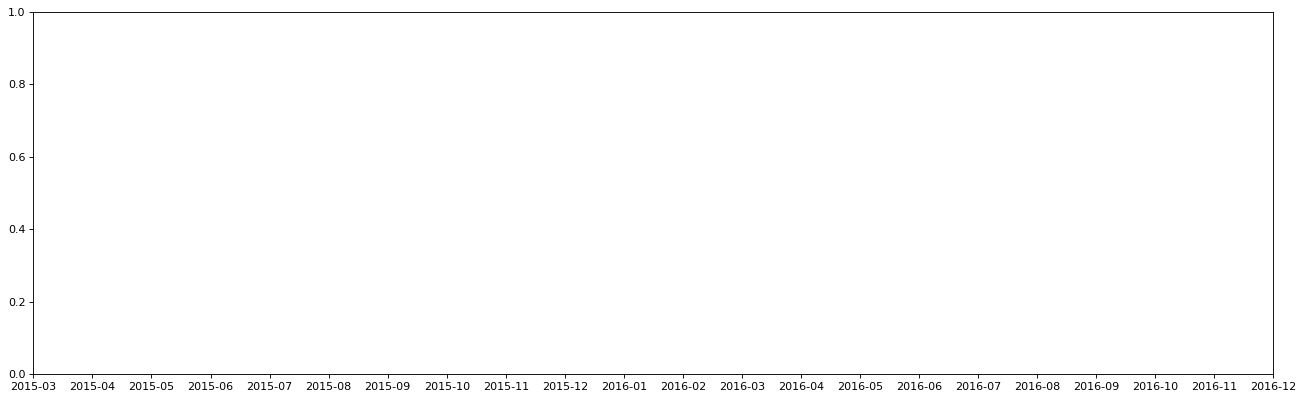

In [41]:
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

times = [e[0][:7] for e in monthTuples]
x = [e for e in range(len(timeTuples))]
plt.xticks(x, times)

plt.plot(sumHillary,label='Clinton')
plt.plot(sumSanders,label='Sanders')
plt.plot(sumTrump,label='Trump')
plt.plot(sumCruz,label='Cruz')

sumCruz
sumSanders

pylab.legend(loc='upper left')
plt.title('Number of comments by month')
plt.ylabel('Number of comments')
plt.show()

# Rod

In [7]:
# Mean margin of error

polls_newDf
new = [[pollsDf[(pollsDf['epochs'] > timeConvert(e[0])) & (pollsDf['epochs'] < timeConvert(e[1]))]['Date']] for e in monthTuples]
new

[[453    March 13–15, 2015
  454    March 13–15, 2015
  457    March 13–15, 2015
  456    March 13–15, 2015
  458    March 13–15, 2015
  459    March 13–15, 2015
  455    March 13–15, 2015
  438    March 26–31, 2015
  439    March 26–31, 2015
  440    March 26–31, 2015
  441    March 26–31, 2015
  444    March 26–31, 2015
  442    March 26–31, 2015
  446    March 26–31, 2015
  445    March 26–31, 2015
  452    March 26–29, 2015
  451    March 26–29, 2015
  443    March 26–31, 2015
  449    March 26–29, 2015
  447    March 26–31, 2015
  450    March 26–29, 2015
  448    March 26–31, 2015
  436    March 29–31, 2015
  435    March 29–31, 2015
  434    March 29–31, 2015
  433    March 29–31, 2015
  437    March 29–31, 2015
  Name: Date, dtype: object], [432    April 9 & 12, 2015
  431    April 9 & 12, 2015
  416    April 16–21, 2015 
  417    April 16–21, 2015 
  418    April 16–21, 2015 
  419    April 16–21, 2015 
  420    April 16–21, 2015 
  421    April 16–21, 2015 
  425    April 16–

In [ ]:


a = [e[2:-1] for e in pollsDf['Margin of error'] if type(e) == str]

b = []
for e in a:
    try:
        b.append(float(e))
    except:
        ValueError

np.mean(b)

In [ ]:
# Word 2 Vec

stopWords = ["a","about","above","after","again","against","ain","all","am","an","and","any","are","aren","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can","couldn","couldn't","d","did","didn","didn't","do","does","doesn","doesn't","doing","don","don't","down","during","each","few","for","from","further","had","hadn","hadn't","has","hasn","hasn't","have","haven","haven't","having","he","her","here","hers","herself","him","himself","his","how","i","if","in","into","is","isn","isn't","it","it's","its","itself","just","ll","m","ma","me","mightn","mightn't","more","most","mustn","mustn't","my","myself","needn","needn't","no","nor","not","now","o","of","off","on","once","only","or","other","our","ours","ourselves","out","over","own","re","s","same","shan","shan't","she","she's","should","should've","shouldn","shouldn't","so","some","such","t","than","that","that'll","the","their","theirs","them","themselves","then","there","these","they","this","those","through","to","too","under","until","up","ve","very","was","wasn","wasn't","we","were","weren","weren't","what","when","where","which","while","who","whom","why","will","with","won","won't","wouldn","wouldn't","y","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","could","he'd","he'll","he's","here's","how's","i'd","i'll","i'm","i've","let's","ought","she'd","she'll","that's","there's","they'd","they'll","they're","they've","we'd","we'll","we're","we've","what's","when's","where's","who's","why's","would","able","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","afterwards","ah","almost","alone","along","already","also","although","always","among","amongst","announce","another","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","arent","arise","around","aside","ask","asking","auth","available","away","awfully","b","back","became","become","becomes","becoming","beforehand","begin","beginning","beginnings","begins","behind","believe","beside","besides","beyond","biol","brief","briefly","c","ca","came","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","couldnt","date","different","done","downwards","due","e","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","ff","fifth","first","five","fix","followed","following","follows","former","formerly","forth","found","four","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","happens","hardly","hed","hence","hereafter","hereby","herein","heres","hereupon","hes","hi","hid","hither","home","howbeit","however","hundred","id","ie","im","immediate","immediately","importance","important","inc","indeed","index","information","instead","invention","inward","itd","it'll","j","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","made","mainly","make","makes","many","may","maybe","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","moreover","mostly","mr","mrs","much","mug","must","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","nobody","non","none","nonetheless","noone","normally","nos","noted","nothing","nowhere","obtain","obtained","obviously","often","oh","ok","okay","old","omitted","one","ones","onto","ord","others","otherwise","outside","overall","owing","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","said","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","shed","shes","show","showed","shown","showns","shows","significant","significantly","similar","similarly","since","six","slightly","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","sufficiently","suggest","sup","sure","take","taken","taking","tell","tends","th","thank","thanks","thanx","thats","that've","thence","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","theyd","theyre","think","thou","though","thoughh","thousand","throug","throughout","thru","thus","til","tip","together","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","unfortunately","unless","unlike","unlikely","unto","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","via","viz","vol","vols","vs","w","want","wants","wasnt","way","wed","welcome","went","werent","whatever","what'll","whats","whence","whenever","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","whim","whither","whod","whoever","whole","who'll","whomever","whos","whose","widely","willing","wish","within","without","wont","words","world","wouldnt","www","x","yes","yet","youd","youre","z","zero","a's","ain't","allow","allows","apart","appear","appreciate","appropriate","associated","best","better","c'mon","c's","cant","changes","clearly","concerning","consequently","consider","considering","corresponding","course","currently","definitely","described","despite","entirely","exactly","example","going","greetings","hello","help","hopefully","ignored","inasmuch","indicate","indicated","indicates","inner","insofar","it'd","keep","keeps","novel","presumably","reasonably","second","secondly","sensible","serious","seriously","sure","t's","third","thorough","thoroughly","three","well","wonder", "shouldnt", "isnt", "havent", "mere"]
start = time.time()    
model = gensim.models.Word2Vec(
        a,
        size=150,
        window=10,
        min_count=2,
        workers=10, 
        iter=10)

model = gensim.models.Word2Vec (documents, size=150, window=10, min_count=2, workers=10)


end = time.time()
print('...Done in '+str(end - start))

model.train(a,total_examples=len(a),epochs=10)
model.wv.most_similar(positive='hillary', topn=50)